# Théorie de la tarification d'options

Le but de ce programme est de comparer les prix d'une option européenne à l'aide de deux méthodes : **Monte Carlo** et **Black-Scholes**. En outre, le code récupère également le prix de l'option sur le marché et effectue une analyse pour déterminer si l'option est surévaluée, sous-évaluée ou correctement évaluée.

## 1. Classe `OptionPricer`

### 1.1 Initialisation

La classe `OptionPricer` est initialisée avec plusieurs paramètres :

- **ticker** : Le symbole boursier de l'actif sous-jacent (par défaut "AAPL").
- **strike_price** : Le prix d'exercice de l'option.
- **maturity_date** : La date d'échéance de l'option. Si aucune date n'est spécifiée, une échéance de 180 jours à partir de la date actuelle est choisie par défaut.
- **risk_free_rate** : Le taux sans risque, qui est utilisé dans les modèles de tarification d'options. Ici, il est fixé à 5 % (0.05).
- **num_simulations** : Le nombre de simulations Monte Carlo à effectuer pour estimer le prix de l'option (par défaut 10 000).

### 1.2 Récupération des données de marché

Le code utilise la bibliothèque `yfinance` pour récupérer les données historiques de l'actif sous-jacent. La volatilité est calculée à partir des rendements quotidiens, tandis que le prix actuel de l'action est extrait à partir des dernières données disponibles.

### 1.3 Volatilité

La volatilité est estimée à partir des rendements quotidiens historiques des actions :

$$
\sigma = \sqrt{252} \times \text{std}(\ln(P_t / P_{t-1}))
$$

Où :
- $\sigma$ est la volatilité annualisée.
- $\text{std}$ est l'écart-type des rendements logarithmiques quotidiens.
- 252 est le nombre de jours de négociation par an.

### 1.4 Calcul du temps à l'échéance

Le temps à l'échéance est calculé en jours, puis converti en années :

$$
T = \frac{\text{Date d'échéance} - \text{Date actuelle}}{365}
$$

Cela permet de mesurer la durée jusqu'à la date d'échéance de l'option.

## 2. Méthodes de tarification

### 2.1 Méthode Monte Carlo

La méthode Monte Carlo est une simulation numérique qui génère plusieurs trajectoires aléatoires pour le prix de l'actif sous-jacent, et en calcule le prix de l'option en fonction de ces trajectoires.

La formule utilisée pour chaque pas de temps $t$ dans la trajectoire de prix est la suivante :

$$
S_{t+1} = S_t \cdot \exp\left( (r - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)
$$

Où :
- $S_t$ est le prix de l'action à l'instant $t$.
- $r$ est le taux sans risque.
- $\sigma$ est la volatilité de l'actif sous-jacent.
- $\Delta t$ est l'intervalle de temps entre les étapes de simulation (en années).
- $Z_t$ est un tirage aléatoire suivant une distribution normale standard.

Le prix de l'option est ensuite calculé comme la moyenne actualisée des payoffs des trajectoires simulées :

$$
\text{Prix option} = \exp(-rT) \times \frac{1}{N} \sum_{i=1}^{N} \max(S_T^i - K, 0)
$$

Où :
- $N$ est le nombre de simulations.
- $S_T^i$ est le prix final simulé de l'actif sous-jacent pour la simulation $i$.
- $K$ est le prix d'exercice.

### 2.2 Méthode Black-Scholes

La méthode de Black-Scholes fournit une formule fermée pour le prix d'une option européenne. Elle repose sur l'hypothèse que l'actif suit un mouvement brownien géométrique. La formule du prix de l'option call européenne est donnée par :

$$
C = S_0 N(d_1) - K \exp(-rT) N(d_2)
$$

Où :
- $S_0$ est le prix actuel de l'actif sous-jacent.
- $K$ est le prix d'exercice.
- $r$ est le taux sans risque.
- $T$ est le temps à l'échéance.
- $N(x)$ est la fonction de répartition de la loi normale standard.
- $d_1$ et $d_2$ sont définis comme suit :

$$
d_1 = \frac{\ln\left( \frac{S_0}{K} \right) + \left( r + \frac{1}{2} \sigma^2 \right) T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

### 2.3 Comparaison des prix

Après avoir calculé les prix via les méthodes Monte Carlo et Black-Scholes, le programme compare également ces valeurs avec le prix de l'option sur le marché. Si le prix du marché est disponible, le programme affiche l'analyse suivante :
- **Surévaluée** : Si le prix du marché est supérieur de plus de 5 % au prix moyen des deux modèles.
- **Sous-évaluée** : Si le prix du marché est inférieur de plus de 5 % au prix moyen des deux modèles.
- **Équitablement évaluée** : Si le prix du marché se trouve dans une plage de 5 % autour du prix moyen des deux modèles.

## 3. Affichage des résultats

Les résultats sont affichés dans un tableau comparatif avec les prix de l'option obtenus par les méthodes Monte Carlo et Black-Scholes, ainsi que le prix du marché (si disponible). Le code génère également un graphique à barres pour visualiser la comparaison entre ces prix.


### 4 Conclusion

D'après l'analyse, l'option semble **surévaluée** sur le marché, car son prix est plus élevé que le prix moyen calculé par les méthodes Monte Carlo et Black-Scholes.

## 5. Visualisation

Le graphique affiche la comparaison des prix entre les trois méthodes (prix du marché, Monte Carlo et Black-Scholes) :

- **Méthode de marché** : Affiche le prix actuel sur le marché.
- **Monte Carlo** : Affiche le prix estimé par simulation Monte Carlo.
- **Black-Scholes** : Affiche le prix estimé par la formule de Black-Scholes.





Option Pricing Analysis - AAPL
Strike Price: 180.00 $
Current Stock Price: 227.48 $
Days to Maturity: 191

Pricing Results:
Method                    Price
------------------------------
Market          $    55.70

Analysis: Option appears OVERVALUED in the market
Monte Carlo              49.62 $
Black-Scholes            53.22 $


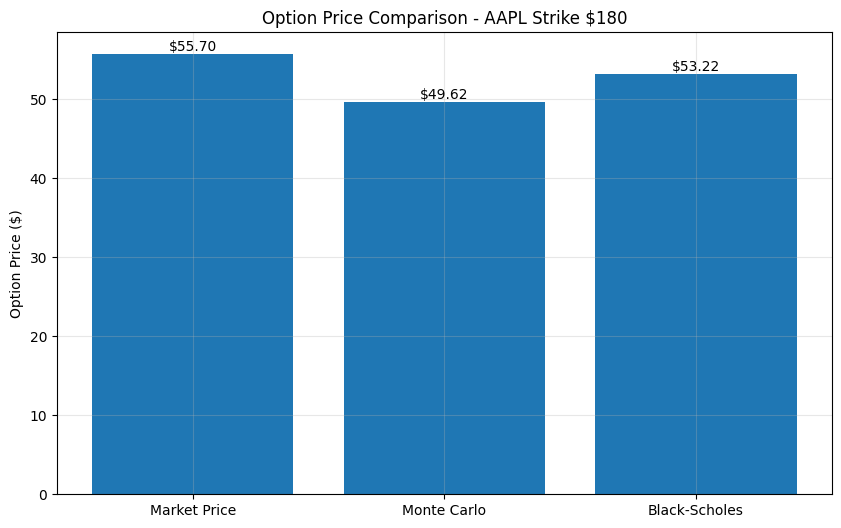

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class OptionPricer:
    def __init__(self, ticker="AAPL", strike_price=180, maturity_date=None, 
                 risk_free_rate=0.05, num_simulations=10000):
        self.ticker = ticker
        self.strike_price = strike_price
        self.stock = yf.Ticker(ticker)
        
        try:
            expirations = self.stock.options
            if maturity_date is None:
                target_date = datetime.now() + timedelta(days=180)
            else:
                target_date = datetime.strptime(maturity_date, "%Y-%m-%d")
            closest_date = min(expirations, 
                             key=lambda x: abs(datetime.strptime(x, "%Y-%m-%d") - target_date))
            self.maturity_date = closest_date
        except Exception:
            self.maturity_date = (datetime.now() + timedelta(days=180)).strftime("%Y-%m-%d")
        
        self.risk_free_rate = risk_free_rate
        self.num_simulations = num_simulations
        self.current_price = self.stock.history(period="1d")['Close'].iloc[-1]
        
        maturity_datetime = datetime.strptime(self.maturity_date, "%Y-%m-%d")
        current_datetime = datetime.now()
        if maturity_datetime <= current_datetime:
            raise ValueError(f"Maturity date {self.maturity_date} must be in the future")
        
        self.time_to_maturity = (maturity_datetime - current_datetime).days / 365.0
        historical_data = self.stock.history(period="1y")
        self.volatility = np.sqrt(252) * historical_data['Close'].pct_change().std()

    def generate_random_walks(self):
        dt = self.time_to_maturity / 252
        num_steps = max(1, int(self.time_to_maturity * 252))
        Z = np.random.standard_normal((self.num_simulations, num_steps))
        paths = np.zeros((self.num_simulations, num_steps + 1))
        paths[:, 0] = self.current_price
        
        for t in range(1, num_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp((self.risk_free_rate - 0.5 * self.volatility**2) * dt + 
                                                self.volatility * np.sqrt(dt) * Z[:, t-1])
        return paths

    def monte_carlo_price(self):
        paths = self.generate_random_walks()
        final_prices = paths[:, -1]
        payoffs = np.maximum(final_prices - self.strike_price, 0)
        return np.exp(-self.risk_free_rate * self.time_to_maturity) * np.mean(payoffs)

    def black_scholes_price(self):
        d1 = (np.log(self.current_price / self.strike_price) + 
              (self.risk_free_rate + 0.5 * self.volatility**2) * self.time_to_maturity) / \
             (self.volatility * np.sqrt(self.time_to_maturity))
        d2 = d1 - self.volatility * np.sqrt(self.time_to_maturity)
        return self.current_price * norm.cdf(d1) - \
               self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(d2)

    def get_market_price(self):
        options = self.stock.option_chain(self.maturity_date)
        calls = options.calls
        closest_strike_idx = (calls['strike'] - self.strike_price).abs().idxmin()
        return calls.iloc[closest_strike_idx]['lastPrice']

    def compare_prices(self):
        mc_price = self.monte_carlo_price()
        bs_price = self.black_scholes_price()
        market_price = self.get_market_price()
        
        print(f"\nOption Pricing Analysis - {self.ticker}")
        print(f"Strike Price: {self.strike_price:.2f} $")
        print(f"Current Stock Price: {self.current_price:.2f} $")
        print(f"Days to Maturity: {self.time_to_maturity*365:.0f}")
        
        print(f"\nPricing Results:")
        print(f"{'Method':<20} {'Price':>10}")
        print("-" * 30)
        
        if market_price is not None:
            print(f"{'Market':<15} ${market_price:>9.2f}")
            avg_model_price = (mc_price + bs_price) / 2
            if market_price > avg_model_price * 1.05:
                print("\nAnalysis: Option appears OVERVALUED in the market")
            elif market_price < avg_model_price * 0.95:
                print("\nAnalysis: Option appears UNDERVALUED in the market")
            else:
                print("\nAnalysis: Option appears FAIRLY PRICED in the market")
        
        print(f"{'Monte Carlo':<20} {mc_price:>9.2f} $")
        print(f"{'Black-Scholes':<20} {bs_price:>9.2f} $")
        
        self.plot_price_comparison(mc_price, bs_price, market_price)
        return mc_price, bs_price, market_price

    def plot_price_comparison(self, mc_price, bs_price, market_price):
        if market_price is not None:
            methods = ['Market Price', 'Monte Carlo', 'Black-Scholes']
            prices = [market_price, mc_price, bs_price]
        else:
            methods = ['Monte Carlo', 'Black-Scholes']
            prices = [mc_price, bs_price]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, prices)
        plt.title(f'Option Price Comparison - {self.ticker} Strike ${self.strike_price}')
        plt.ylabel('Option Price ($)')
        plt.grid(True, alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:.2f}',
                    ha='center', va='bottom')
        plt.show()

if __name__ == "__main__":
    pricer = OptionPricer(
        ticker="AAPL",
        strike_price=180,
        risk_free_rate=0.05,
        num_simulations=10000
    )
    mc_price, bs_price, market_price = pricer.compare_prices()
